In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

**Uploading data from Google Drive and shuffle it**

In [0]:
app_data = pd.read_csv("gdrive/My Drive/Diplom/data.csv")
app_data.reindex(np.random.permutation(app_data.index))
app_data.head(5)

Unnamed: 0  CustomerID LoanType  ... Isapproved Inrange Hasjson
0           0    161181.0      New  ...        1.0     1.0     1.0
1           1     47669.0   Repeat  ...        1.0     1.0     1.0
2           2    161860.0      New  ...        1.0     1.0     1.0
3           3     71471.0   Repeat  ...        1.0     1.0     1.0
4           4    146056.0   Repeat  ...        1.0     1.0     1.0

[5 rows x 217 columns]


Delete columns that are missing more than **bound_of_missing_values**

In [0]:
def remove_missing_values_table(df, bound_of_missing_values = 5):
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    remove_cols = []
    for col in df:
        if(mis_val_percent[col] > bound_of_missing_values):
            remove_cols.append(col)
    df = df.drop(labels = remove_cols,axis = 1)
    return df
app_data = remove_missing_values_table(app_data)

replace the **NaN** values with the most popular ones in the column

In [0]:
def fillna(col):
    col.fillna(col.value_counts().index[0], inplace=True)
    return col
app_data=app_data.apply(lambda col:fillna(col))

encode categorical features

In [0]:
labelencoder = LabelEncoder()
for col in app_data.select_dtypes('object'):
    labelencoder.fit(app_data[col])
    app_data[col] = labelencoder.transform(app_data[col])

split the data into training and test data. Here we remove the **IsWrittenOff** and  **MaxCdia** columns because they give an auc result close to 1

In [0]:
labels = app_data['Isdefault']
data = app_data.drop(labels = ['Isdefault','IsWrittenOff','MaxCdia'],axis = 1).copy()
print(data.shape)
print(labels.shape)

test_size = 0.70
num = (int)(test_size * data.shape[0])

train_data = data[:num]
test_data = data[num:]

train_labels = labels[:num]
test_labels = labels[num:]

(12980, 109)
(12980,)


Normalize data

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

scaler = MinMaxScaler(feature_range = (0, 1))
#scaler = StandardScaler()

scaler.fit(data)
transformData = scaler.transform(data)

transform_train_data = transformData[:num]
transform_test_data  = transformData[num:]

In [0]:


preds = []
namesModel = []
#this function draws a graph of roc
def plot_roc(predictions,name = 'Model'):
    preds.append(predictions)
    namesModel.append(name)

    fpr, tpr, threshold = metrics.roc_curve(test_labels, predictions)
    auc = metrics.auc(fpr, tpr)

    plt.title(name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.show()
    return auc


def printAllModels():
    print(namesModel)
    cnt = len(preds)
    for i in range(cnt):
        plot_roc(preds[i],names[i])
    plt.show()

Cross validation score

In [0]:
from sklearn.model_selection import StratifiedKFold
def compute_roc_auc(clf,index,isTransformed = False):
    
    if(isTransformed):
        y_predict = clf.predict_proba(transformData.iloc[index])[:,1]
    else:
        y_predict = clf.predict_proba(data.iloc[index])[:,1]
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(labels.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return auc_score

def cv_score(clf,n_splits = 5,isTransformed = False):

    cv = StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    scores = []
    scores_acc = []
    
    for (train, test), i in zip(cv.split(data, labels), range(n_splits)):
        if(isTransformed):
            clf.fit(transformData.iloc[train], labels.iloc[train])
        else:
            clf.fit(data.iloc[train], labels.iloc[train])

        auc_score = compute_roc_auc(clf,test)
        scores.append(auc_score)
        
        if(isTransformed):
            y_pred = clf.predict(transformData.iloc[test])
        else:
            y_pred = clf.predict(data.iloc[test])
        y_pred = clf.predict(data.iloc[test])
        
        scores_acc.append(accuracy_score(labels.iloc[test], y_pred))
        
        
    
    print('accuracyCV ',scores_acc)
    print('mean = ',np.mean(scores_acc))
    print(pd.DataFrame(scores, columns=['AUC CV'])) 

Consider some of the models

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

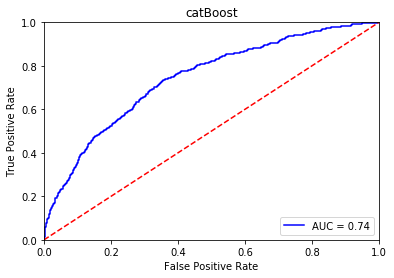

accuracy =  0.8479712378017463


In [0]:
# CatBoost

from catboost import CatBoostClassifier,Pool
categorical_features_indices = np.where(train_data.dtypes != np.float)[0]
cb = CatBoostClassifier(iterations=1000,learning_rate=0.03, depth=6,custom_loss = ['AUC','Accuracy'],l2_leaf_reg=1)
cat_f_test = np.where(train_data.dtypes != np.float)[0]
cb.fit(train_data ,train_labels,cat_features=  categorical_features_indices,
       verbose = False,plot = True,eval_set=(test_data,test_labels),early_stopping_rounds=200)

predictions = cb.predict_proba(test_data)[:,1]
plot_roc(predictions,'catBoost')

predClass = cb.predict(test_data)
acc = accuracy_score(test_labels,predClass)
print('accuracy = ',acc)

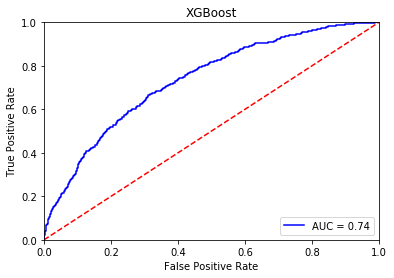

accuracy =  0.8443759630200308
accuracyCV  [0.8301232665639445, 0.827426810477658, 0.8235747303543913, 0.8278120184899846, 0.8235747303543913]
mean =  0.8265023112480738
     AUC CV
0  0.726286
1  0.716563
2  0.719584
3  0.719139
4  0.721428


In [0]:
# XGBoost

from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=90,max_depth=3,learning_rate=0.1)
xgb.fit(train_data,train_labels)

predictions = xgb.predict_proba(test_data)[:,1]
plot_roc(predictions,'XGBoost')

predClass = xgb.predict(test_data)
acc = accuracy_score(test_labels,predClass)
print('accuracy = ',acc)

cv_score(xgb)

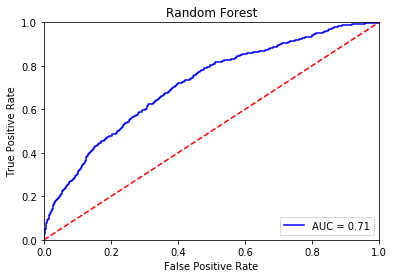

accuracy =  0.8412942989214176
accuracyCV  [0.8247303543913713, 0.8247303543913713, 0.8231895223420647, 0.8228043143297381, 0.8247303543913713]
mean =  0.8240369799691832
     AUC CV
0  0.712168
1  0.698992
2  0.705700
3  0.707617
4  0.711845


In [0]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 800, max_depth= 10,random_state = 50)
random_forest.fit(train_data,train_labels)

predictions = random_forest.predict_proba(test_data)[:,1]
plot_roc(predictions,'Random Forest')

predClass = random_forest.predict(test_data)
acc = accuracy_score(test_labels,predClass)
print('accuracy = ',acc)

cv_score(random_forest)

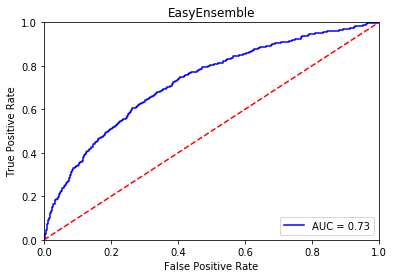

accuracy =  0.7131484334874165
accuracyCV  [0.6571648690292758, 0.6448382126348228, 0.637904468412943, 0.6471494607087828, 0.6563944530046225]
mean =  0.6486902927580893
     AUC CV
0  0.721880
1  0.715507
2  0.708994
3  0.723599
4  0.713227


In [0]:
# EasyEnsemble

from imblearn.ensemble import EasyEnsembleClassifier
EEC = EasyEnsembleClassifier(n_estimators=10)
EEC.fit(train_data,train_labels)

predictions = EEC.predict_proba(test_data)[:,1]
plot_roc(predictions,'EasyEnsemble')

predClass = EEC.predict(test_data)
acc = accuracy_score(test_labels,predClass)
print('accuracy = ',acc)

cv_score(EEC)

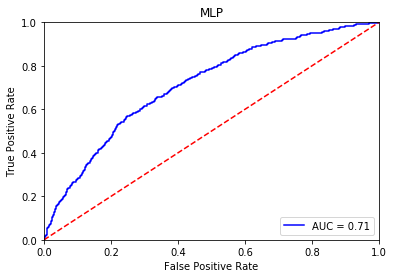

accuracy =  0.8407806882383153


In [0]:
# MLP

from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(250, ), activation='logistic', solver='adam'
                    , alpha=0.01, batch_size='auto',
                    learning_rate='constant', learning_rate_init=0.01)

mlp_clf.fit(transform_train_data, train_labels)

predictions = mlp_clf.predict_proba(transform_test_data)[:,1]
plot_roc(predictions,'MLP')


predClass = mlp_clf.predict(transform_test_data)
acc = accuracy_score(test_labels,predClass)
print('accuracy = ',acc)



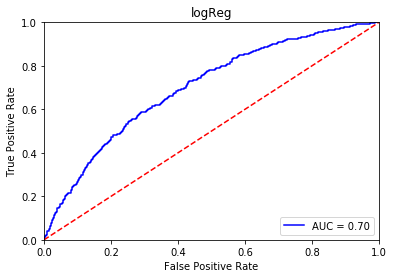

accuracy =  0.8412942989214176


In [0]:
#  LogisticRegression

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C = 0.01)
log_reg.fit(transform_train_data, train_labels)

predictions = log_reg.predict_proba(transform_test_data)[:,1]
plot_roc(predictions,'logReg')

predClass = log_reg.predict(transform_test_data)
acc = accuracy_score(test_labels,predClass)
print('accuracy = ',acc)


output the most important features

feature  importance
50   availableBalance_All    3.804567
86         AtmWithdrawals    3.358998
5       Employment.Length    2.531942
7         RequestedAmount    2.392953
70                 Salary    2.248944
..                    ...         ...
0              Unnamed: 0    0.000000
68              TDatePart    0.000000
21                Product    0.000000
4        Application.Date    0.000000
108               Hasjson    0.000000

[109 rows x 2 columns]

<Figure size 1440x1080 with 0 Axes>

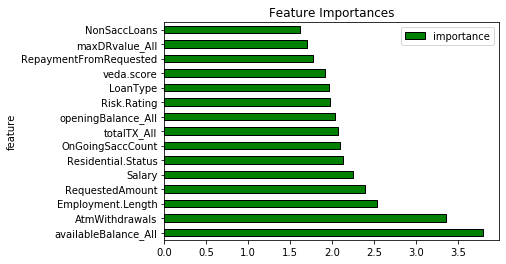

In [0]:
def show_feature_importances(model, features):
    plt.figure(figsize = (20, 15))

    results = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results = results.sort_values('importance', ascending = False)
    
    results.head(15).plot(x = 'feature', y = 'importance', kind = 'barh',
                     color = 'green', edgecolor = 'k', title = 'Feature Importances');
    return results
feat = data.columns
show_feature_importances(cb, feat)


Draw a ROC graph for all models

['catBoost', 'xgb', 'Random Forest', 'EasyEnsemble', 'MLP', 'logReg']


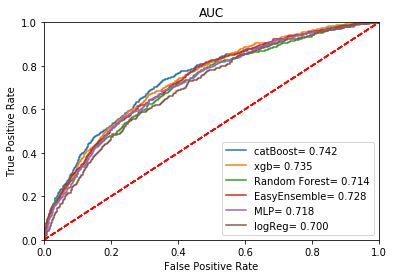

In [0]:
printAllModels()